# distance and direciton

Let try to opt for distance and direction with

$L1loss(y_1-y_0, y_{true})$

where $y_1=model(x_1)$

So I'm optimising for the hidden states to be the correct distance and direcioton away. It's like the margin raning loss.


links:
- [loading](https://github.com/deep-diver/LLM-As-Chatbot/blob/main/models/alpaca.py)
- [dict](https://github.com/deep-diver/LLM-As-Chatbot/blob/c79e855a492a968b54bac223e66dc9db448d6eba/model_cards.json#L143)
- [prompt_format](https://github.com/deep-diver/PingPong/blob/main/src/pingpong/alpaca.py)

In [1]:
# import your package
%load_ext autoreload
%autoreload 2

In [2]:

import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
plt.style.use('ggplot')

from typing import Optional, List, Dict, Union

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch import optim
from torch.utils.data import random_split, DataLoader, TensorDataset

from pathlib import Path

import transformers

import lightning.pytorch as pl
# from dataclasses import dataclass

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from sklearn.preprocessing import RobustScaler

from tqdm.auto import tqdm
import os

from loguru import logger
logger.add(os.sys.stderr, format="{time} {level} {message}", level="INFO")



transformers.__version__


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please run

python -m bitsandbytes

 and submit this information together with your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
bin /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so
CUDA SETUP: CUDA runtime path found: /home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so.11.0
CUDA SETUP: Highest compute capability among GPUs detected: 8.6
CUDA SETUP: Detected CUDA version 117
CUDA SETUP: Loading binary /home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/libbitsandbytes_cuda117.so...


/home/ubuntu/mambaforge/envs/dlk3/lib/python3.11/site-packages/bitsandbytes/cuda_setup/main.py:149: UserWarning: Found duplicate ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] files: {PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so.11.0'), PosixPath('/home/ubuntu/mambaforge/envs/dlk3/lib/libcudart.so')}.. We'll flip a coin and try one of these, in order to fail forward.
Either way, this might cause trouble in the future:
If you get `CUDA error: invalid device function` errors, the above might be the cause and the solution is to make sure only one ['libcudart.so', 'libcudart.so.11.0', 'libcudart.so.12.0'] in the paths that we search based on your env.
  warn(msg)


'4.31.0'

In [3]:
from src.helpers.lightning import read_metrics_csv

# Datasets



In [4]:
from datasets import load_from_disk, concatenate_datasets
from src.datasets.load import ds2df

feats = ['hidden_states', 'head_activation_and_grad', 'mlp_activation_and_grad', 'residual_stream', 'w_grads_attn', 'w_grads_mlp', 'hidden_states2', 'residual_stream2', ]

fs = [
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_6000',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_amazon_polarity_train_3000'
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_300',
    
    # 2023-09-16 13:46:11
    # '../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_250',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_amazon_polarity_train_300',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_super_glue:boolq_train_250',
    # '../.ds/WizardLMWizardCoder_3B_V1.0_tweet_eval:irony_train_250',
    
    '../../.ds/WizardLMWizardCoder_3B_V1.0_amazon_polarity_train_3260',
    '../../.ds/WizardLMWizardCoder_3B_V1.0_super_glue:boolq_train_3260',
    '../../.ds/WizardLMWizardCoder_3B_V1.0_glue:qnli_train_3260',
    # '../../.ds/WizardLMWizardCoder_3B_V1.0_imdb_train_3260',
    
]

dss = [load_from_disk(f) for f in fs]


## QC datasets

In [5]:
import json
def get_ds_name(ds):
    return json.loads(ds.info.description)['ds_name']
    


In [6]:
def filter_ds_to_known(ds1, verbose=True):
    """filter the dataset to only those where the model knows the answer"""
    
    # first get the rows where it answered the question correctly
    df = ds2df(ds1)
    d = df.query('sys_instr_name=="truth"').set_index("example_i")
    m1 = d.llm_ans==d.label_true
    known_indices = d[m1].index
    known_rows = df['example_i'].isin(known_indices)
    known_rows_i = df[known_rows].index
    
    if verbose: print(f"select rows are {m1.mean():2.2%} based on knowledge")
    return ds1.select(known_rows_i)

In [7]:
# # r['attention_mask']
# ds = dss[0]
# ds.features
# # ds['prompt_truncated'].map(lambda s:s.startswith('<|endoftext|>'))
# ds2 = ds.map(lambda x: {'truncated': x['prompt_truncated'].startswith('<|endoftext|>')})
# ds2['truncated']

In [8]:
# # r['attention_mask']
# ds = dss[0]
# ds.features
# # ds['prompt_truncated'].map(lambda s:s.startswith('<|endoftext|>'))
# ds2 = ds.map(lambda x: {'truncated': x['attention_mask'].sum(-1)}, batched=True)
# ds2
# ds


In [9]:
for ds in dss:
    ds_name = get_ds_name(ds)
    print('ds', ds_name)
    df = ds2df(ds)
    
    # check llm accuracy
    d = df.query('instructed_to_lie==False')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tacc    =\t{acc:2.2%} [N={len(d)}] - when the model is not lying... we get this task acc")
    
    # check LLM lie freq
    d = df.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tlie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie... we get this acc")
    
    # check LLM lie freq
    ds_known = filter_ds_to_known(ds, verbose=False)
    df_known = ds2df(ds_known)
    d = df_known.query('instructed_to_lie==True')
    acc = (d.label_instructed==d.llm_ans).mean()
    assert np.isfinite(acc)
    print(f"\tknown_lie_acc=\t{acc:2.2%} [N={len(d)}] - when the model tries to lie and knows the answer... we get this acc")
    
    # check choice coverage
    mean_prob = ds['choice_probs0'].sum(-1).mean()
    print(f"\tchoice_cov=\t{mean_prob:2.2%} - Our choices accounted for a mean probability of this")
    
    # check truncation
    
    # # X mean and std, dtype, shape
    # for f in feats:
    #     if f not in ds.column_names:
    #         continue
    #     X = ds[f]
    #     if X.ndim>3:
    #         for i in range(X.shape[3]):
    #             X2 = X[:,:,:,i]
    #             print(f"\t{f}\tf={i} m={X2.mean():2.2f} s={X2.std():2.2g} {X2.dtype} {X2.shape}")
    #     else:
    #         print(f"\t{f}\tm={X.mean():2.2f} s={X.std():2.2g} {X.dtype} {X.shape}")
    
    
    # # view prompt example
    # r = ds[0]
    # print('prompt example:')
    # print(r['prompt_truncated'], end="")
    # print(r['txt_ans0'])
    
    # print('='*80)
    # print()
        

ds amazon_polarity
	acc    =	49.91% [N=1677] - when the model is not lying... we get this task acc
	lie_acc=	47.88% [N=1583] - when the model tries to lie... we get this acc
	known_lie_acc=	46.56% [N=786] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	78.99% - Our choices accounted for a mean probability of this
ds super_glue:boolq
	acc    =	52.72% [N=1781] - when the model is not lying... we get this task acc
	lie_acc=	54.02% [N=1479] - when the model tries to lie... we get this acc
	known_lie_acc=	54.81% [N=759] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	56.94% - Our choices accounted for a mean probability of this
ds glue:qnli
	acc    =	47.79% [N=1630] - when the model is not lying... we get this task acc
	lie_acc=	48.10% [N=1630] - when the model tries to lie... we get this acc
	known_lie_acc=	64.06% [N=779] - when the model tries to lie and knows the answer... we get this acc
	choice_cov=	73.15% - Our choi

# Combine

In [10]:
dss_known = [filter_ds_to_known(d) for d in dss]
# './.ds/HuggingFaceH4starchat_beta-None-N_8000-ns_3-mc_0.2-2ffc1e'
ds = concatenate_datasets(dss_known)
ds

select rows are 49.91% based on knowledge
select rows are 52.72% based on knowledge
select rows are 47.79% based on knowledge


Dataset({
    features: ['scores0', 'ds_index', 'hidden_states', 'residual_stream', 'hidden_states2', 'residual_stream2', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'truncated', 'prompt_truncated', 'choice_probs0', 'ans0', 'txt_ans0'],
    num_rows: 4879
})

## Filter

In [11]:
# lets select only the ones where
df = ds2df(ds)
df

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,truncated,prompt_truncated,choice_probs0,ans0,txt_ans0,dir_true,llm_ans
0,12,amazon_polarity,6,increase,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,0,1,True,guard,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.54939187, 0.38353732]",0.411106,decrease,0.411106,False
1,13,amazon_polarity,6,Yes,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,0,0,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.76138747, 0.16725463]",0.180105,Yes,0.180105,False
2,14,amazon_polarity,7,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.0023154975, 0.9789686]",0.997630,increase,0.997630,True
3,15,amazon_polarity,7,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.0030933544, 0.9872083]",0.996866,No,0.996866,True
4,16,amazon_polarity,8,increase,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,0,1,True,guard,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.43292427, 0.52220637]",0.546732,increase,0.546732,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4874,3249,glue:qnli,1624,yes,"Below is an instruction that describes a task,...","[yes, no]",based only on,0,0,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.2502056, 0.23140235]",0.480469,yes,0.480469,False
4875,3254,glue:qnli,1627,yes,You are an AI assistant that always tells a li...,"[yes, no]",possible to answer,1,0,True,lie_for_charity,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.42202544, 0.336468]",0.443595,yes,0.443595,False
4876,3255,glue:qnli,1627,no,"Below is an instruction that describes a task,...","[yes, no]",based only on,1,1,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.2592905, 0.28035986]",0.519512,no,0.519512,True
4877,3258,glue:qnli,1629,yes,You are an AI assistant that always tells a li...,"[yes, no]",possible to answer,1,0,True,lie_for_charity,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.38550064, 0.3402031]",0.468784,yes,0.468784,False


In [12]:
# QC: make sure we didn't lose all of the successful lies, which would make the problem trivial
df2= ds2df(ds)
df_subset_successull_lies = df2.query("instructed_to_lie==True & (llm_ans==label_instructed)")
print(f"filtered to {len(df_subset_successull_lies)} num successful lies out of {len(df2)} dataset rows")
assert len(df_subset_successull_lies)>0, "there should be successful lies in the dataset"

filtered to 1281 num successful lies out of 4879 dataset rows


## Transform: Normalize by activation

In [13]:
# N = 1000
# small_ds = ds.select(range(N))
# b = N
# hs0 = small_ds['hs0'].reshape((b, -1))

# scaler = RobustScaler()
# hs1 = scaler.fit_transform(hs0)

# def normalize_hs(hs0, hs1):
#     shape=hs0.shape
#     b = len(hs0)
#     hs0 = scaler.transform(hs0.reshape((b, -1))).reshape(shape)
#     hs1 = scaler.transform(hs1.reshape((b, -1))).reshape(shape)
#     return {'hs0':hs0, 'hs1': hs1}

# # Plot
# plt.hist(hs0.flatten(), bins=155, range=[-5, 5], label='before', histtype='step')
# plt.hist(hs1.flatten(), bins=155, range=[-5, 5], label='after', histtype='step')
# plt.legend()
# plt.show()

# # # Test
# # small_dataset = ds.select(range(4))
# # small_dataset.map(normalize_hs, batched=True, batch_size=2, input_columns=['hs0', 'hs1'])

# # run
# ds = ds.map(normalize_hs, batched=True, input_columns=['hs0', 'hs1'])
# ds

## Lightning DataModule

In [14]:
df = ds2df(ds)
df.head(4)

,ds_index,ds_string,example_i,answer,question,answer_choices,template_name,label_true,label_instructed,instructed_to_lie,sys_instr_name,truncated,prompt_truncated,choice_probs0,ans0,txt_ans0,dir_true,llm_ans
0,12,amazon_polarity,6,increase,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,0,1,True,guard,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.54939187, 0.38353732]",0.411106,decrease,0.411106,False
1,13,amazon_polarity,6,Yes,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,0,0,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.76138747, 0.16725463]",0.180105,Yes,0.180105,False
2,14,amazon_polarity,7,decrease,You are about to immerse yourself into a logic...,"[decrease, increase]",would_you_buy,1,0,True,guard,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.0023154975, 0.9789686]",0.997630,increase,0.997630,True
3,15,amazon_polarity,7,No,"Below is an instruction that describes a task,...","[Yes, No]",Is_this_review_negative,1,1,False,truth,False,<|endoftext|><|endoftext|><|endoftext|><|endof...,"[0.0030933544, 0.9872083]",0.996866,No,0.996866,True


In [15]:
from src.helpers import switch2bool, bool2switch
from src.datasets.dm import imdbHSDataModule
from einops import reduce, einsum, rearrange


def dice_loss(input, target):
    smooth = 1.

    iflat = input.view(-1)
    tflat = target.view(-1)
    intersection = (iflat * tflat).sum()
    
    return 1 - ((2. * intersection + smooth) /
              (iflat.sum() + tflat.sum() + smooth))

In [16]:
# from src.probes.pl_ranking import PLRanking
# from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


# class PLConvProbe(PLRanking):
#     def __init__(self, c_in, total_steps, x_feats = [0], lr=4e-3, weight_decay=1e-9, **kwargs):
#         super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
#         self.probe = nn.Linear(c_in, 1).to(device)
#         self.save_hyperparameters()
        
        
#     def _step(self, batch, batch_idx, stage='train'):
#         h = self.hparams
#         x0, y = batch
#         if x0.ndim == 3:
#             x0 = x0.unsqueeze(-1)
#         x0 = rearrange(x0, 'b l h x -> b (l h x)')
#         x0 = x0.to(device)
#         y_pred_logit = self(x0)
#         y_pred = F.sigmoid(y_pred_logit)
        
#         if stage=='pred':
#             return y_pred.float()
        
#         loss = dice_loss(y_pred, y)
        
#         y_cls = y_pred>0.5 # switch2bool(ypred1-ypred0)
#         self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
#         # self.log(f"{stage}/f1", f1_score(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # converts to labels... but maybe represents the imbalance?
#         self.log(f"{stage}/auroc", auroc(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False)
#         self.log(f"{stage}/dice", dice(y_pred, y>0.5), on_epoch=True, on_step=False)
#         # self.log(f"{stage}/jaccard", jaccard_index(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # meh converts to labels
#         self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
#         self.log(f"{stage}/n", float(len(y)), on_epoch=True, on_step=False, reduce_fx=torch.sum)
#         return loss

In [17]:
from src.probes.pl_ranking import PLRanking
from torchmetrics.functional import accuracy, auroc, f1_score, jaccard_index, dice


class PLConvProbe2(PLRanking):
    def __init__(self, c_in, total_steps, lr=4e-3, weight_decay=1e-9, **kwargs):
        super().__init__(total_steps=total_steps, lr=lr, weight_decay=weight_decay)
        self.save_hyperparameters()
        
        self.pre = nn.Sequential(
            nn.Conv1d(c_in, c_in//8, kernel_size=2, stride=1, padding=0, bias=True),
            nn.ReLU(),
            )
        self.probe = nn.Sequential(
            nn.Linear(c_in//8, c_in//8),
            nn.ReLU(),
            nn.Linear(c_in//8, 1),
        )
        
        
    def _step(self, batch, batch_idx, stage='train'):
        h = self.hparams
        x0, y = batch
        if x0.ndim == 3:
            x0 = x0.unsqueeze(-1)
        x0 = rearrange(x0, 'b l h x -> b (l h) x')
        x0 = x0.to(device)
        hs = self.pre(x0)
        hs = rearrange(hs, 'b h x -> b (h x)')
        y_pred_logit = self.probe(hs)
        y_pred = F.sigmoid(y_pred_logit).squeeze(-1)
        
        if stage=='pred':
            return y_pred.float()
        
        loss = dice_loss(y_pred, y)
        
        y_cls = y_pred>0.5 # switch2bool(ypred1-ypred0)
        self.log(f"{stage}/acc", accuracy(y_cls, y>0.5, "binary"), on_epoch=True, on_step=False)
        # self.log(f"{stage}/f1", f1_score(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # converts to labels... but maybe represents the imbalance?
        self.log(f"{stage}/auroc", auroc(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False)
        self.log(f"{stage}/dice", dice(y_pred, y>0.5), on_epoch=True, on_step=False)
        # self.log(f"{stage}/jaccard", jaccard_index(y_pred, y>0.5, "binary"), on_epoch=True, on_step=False) # meh converts to labels
        self.log(f"{stage}/loss", loss, on_epoch=True, on_step=False)
        self.log(f"{stage}/n", float(len(y)), on_epoch=True, on_step=False, reduce_fx=torch.sum)
        return loss

In [18]:
# params
batch_size = 120
lr = 1e-3
wd = 1

max_epochs = 50
device = 'cuda'

# quiet please
torch.set_float32_matmul_precision('medium')
import warnings
warnings.filterwarnings("ignore", ".*does not have many workers.*")
warnings.filterwarnings("ignore", ".*sampler has shuffling enabled, it is strongly recommended that.*")
warnings.filterwarnings("ignore", ".*has been removed as a dependency of.*")

In [19]:
def get_acc_subset(df, query, verbose=True):
    if query: df = df.query(query)
    acc = (df['probe_pred']==df['y']).mean()
    if verbose:
        print(f"acc={acc:2.2%},\tn={len(df)},\t[{query}] ")
    return acc

def calc_metrics(dm, trainer, net, use_val=False, verbose=True):
    dl_test = dm.test_dataloader()
    rt = trainer.predict(net, dataloaders=dl_test)
    y_test_pred = np.concatenate(rt)
    splits = dm.splits['test']
    df_test = dm.df.iloc[splits[0]:splits[1]].copy()
    df_test['probe_pred'] = y_test_pred>0.5
    
    if use_val:
        dl_val = dm.val_dataloader()
        rv = trainer.predict(net, dataloaders=dl_val)
        y_val_pred = np.concatenate(rv)
        splits = dm.splits['val']
        df_val = dm.df.iloc[splits[0]:splits[1]].copy()
        df_val['probe_pred'] = y_val_pred>0.5
        
        df_test = pd.concat([df_val, df_test])

    if verbose:
        print('probe results on subsets of the data')
    acc = get_acc_subset(df_test, '', verbose=verbose)
    get_acc_subset(df_test, 'instructed_to_lie==True', verbose=verbose) # it was ph told to lie
    get_acc_subset(df_test, 'instructed_to_lie==False', verbose=verbose) # it was told not to lie
    get_acc_subset(df_test, 'llm_ans==label_true', verbose=verbose) # the llm gave the true ans
    get_acc_subset(df_test, 'llm_ans==label_instructed', verbose=verbose) # the llm gave the desired ans
    acc_lie_lie = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=verbose) # it was told to lie, and it did lie
    acc_lie_truth = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=verbose)
    
    a = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans==label_instructed', verbose=False)
    b = get_acc_subset(df_test, 'instructed_to_lie==False & llm_ans!=label_instructed', verbose=False)
    c = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans==label_instructed', verbose=False)
    d = get_acc_subset(df_test, 'instructed_to_lie==True & llm_ans!=label_instructed', verbose=False)
    d1 = pd.DataFrame([[a, b], [c, d]], index=['instructed_to_lie==False', 'instructed_to_lie==True'], columns=['llm_ans==label_instructed', 'llm_ans!=label_instructed'])
    d1 = pd.DataFrame([[a, b], [c, d]], index=['tell a truth', 'tell a lie'], columns=['did', 'didn\'t'])
    d1.index.name = 'instructed to'
    d1.columns.name = 'llm gave'
    print('probe accuracy for quadrants')
    display(d1.round(2))
    
    if verbose:
        print(f"⭐PRIMARY METRIC⭐ acc={acc:2.2%} from probe")
        print(f"⭐SECONDARY METRIC⭐ acc_lie_lie={acc_lie_lie:2.2%} from probe")
    return dict(acc=acc, acc_lie_lie=acc_lie_lie, acc_lie_truth=acc_lie_truth)

In [20]:
import re
def transform_dl_k(k: str) -> str:
    p = re.match(r'test\/(.+)\/dataloader_idx_\d', k)
    return p.group(1) if p else k

def rename(rs):
    ks = ['train', 'val', 'test']
    rs = {ks[i]: {transform_dl_k(k):v for k,v in rs[i].items()} for i in range(3)}
    return rs

In [21]:
from src.datasets.dm import to_ds, to_tensor

x_cols = ['hidden_states', 'residual_stream', 'hidden_states2', 'residual_stream2',]
 
class imdbHSDataModule2(imdbHSDataModule):


    def setup(self, stage: str):
        h = self.hparams
        
        # extract data set into N-Dim tensors and 1-d dataframe
        self.ds_hs = (
            self.ds.select_columns(x_cols)
            .with_format("numpy")
        )
        df = self.df = ds2df(self.ds)
        
        y_cls = y = df['label_true'] == df['llm_ans']
        
        self.y = y_cls.values
        self.df['y'] = y_cls
        
        b = len(self.ds_hs)
        self.hs0 = self.ds_hs['residual_stream']
        # d = self.ds_hs['residual_stream2']
        # self.hs0 = np.stack([c, d], axis=-1)
        # rearrange(self.hs0, 'b l hs  -> b hs s')
        #.transpose(0, 2, 1)
        # self.hs1 = self.ds_hs['hs1'].transpose(0, 2, 1)
        self.ans0 = self.df['ans0'].values
        # self.ans1 = self.df['ans1'].values

        # let's create a simple 50/50 train split (the data is already randomized)
        n = len(self.y)
        self.splits = {
            'train': (0, int(n * 0.5)),
            'val': (int(n * 0.5), int(n * 0.75)),
            'test': (int(n * 0.75), n),
        }
        
        self.datasets = {key: to_ds(self.hs0[start:end], self.y[start:end]) for key, (start, end) in self.splits.items()}


In [23]:
max_rows = 4000
ds2 = ds.shuffle(42).select(range(max_rows))
ds2

Dataset({
    features: ['scores0', 'ds_index', 'hidden_states', 'residual_stream', 'hidden_states2', 'residual_stream2', 'ds_string', 'example_i', 'answer', 'question', 'answer_choices', 'template_name', 'label_true', 'label_instructed', 'instructed_to_lie', 'sys_instr_name', 'truncated', 'prompt_truncated', 'choice_probs0', 'ans0', 'txt_ans0'],
    num_rows: 4000
})

In [24]:
# max_rows = 1000
# ds2 = ds.select(range(max_rows))
# TEMP try with the counterfactual residual stream...
dm = imdbHSDataModule2(ds2, batch_size=batch_size)
dm.setup('train')

In [25]:
dl_train = dm.train_dataloader()
dl_val = dm.val_dataloader()
print(len(dl_train), len(dl_val))
x, y = next(iter(dl_train))
print(x.shape, 'x')
if x.ndim==3: x = x.unsqueeze(-1)

c_in = np.prod(x.shape[1:-1])
net = PLConvProbe2(c_in=c_in, total_steps=max_epochs*len(dl_train),  lr=lr, 
        weight_decay=wd, depth=3,
        # x_feats=x_feats
        )
print(net)

17 9
torch.Size([120, 7, 2816, 2]) x
PLConvProbe2(
  (pre): Sequential(
    (0): Conv1d(19712, 2464, kernel_size=(2,), stride=(1,))
    (1): ReLU()
  )
  (probe): Sequential(
    (0): Linear(in_features=2464, out_features=2464, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2464, out_features=1, bias=True)
  )
)


Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type       | Params
-------------------------------------
0 | pre   | Sequential | 97.1 M
1 | probe | Sequential | 6.1 M 
-------------------------------------
103 M     Trainable params
0         Non-trainable params
103 M     Total params
412.878   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: 0it [00:00, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃   Runningstage.testing    ┃                           ┃                           ┃                           ┃
┃          metric           ┃       DataLoader 0        ┃       DataLoader 1        ┃       DataLoader 2        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test/acc          │     0.737500011920929     │    0.7450000047683716     │    0.7440000176429749     │
│        test/auroc         │            0.5            │            0.5            │            0.5            │
│         test/dice         │    0.8483560681343079     │    0.8531985282897949     │    0.8527430295944214     │
│         test/loss         │    0.15090522170066833    │    0.14605338871479034    │    0.1465074121952057     │
│          test/n           │          2000.0           │          1000.0           │          1000.0           │
└───────────────────────────┴───────────────────────────┴───────────────────────────┴───────────────────────────┘

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

probe results on subsets of the data
acc=74.45%,	n=2000,	[] 
acc=46.49%,	n=955,	[instructed_to_lie==True] 
acc=100.00%,	n=1045,	[instructed_to_lie==False] 
acc=100.00%,	n=1489,	[llm_ans==label_true] 
acc=67.16%,	n=1556,	[llm_ans==label_instructed] 
acc=0.00%,	n=511,	[instructed_to_lie==True & llm_ans==label_instructed] 
acc=100.00%,	n=444,	[instructed_to_lie==True & llm_ans!=label_instructed] 
probe accuracy for quadrants


llm gave,did,didn't
instructed to,,
tell a truth,1.0,NaN
tell a lie,0.0,1.0


⭐PRIMARY METRIC⭐ acc=74.45% from probe
⭐SECONDARY METRIC⭐ acc_lie_lie=0.00% from probe


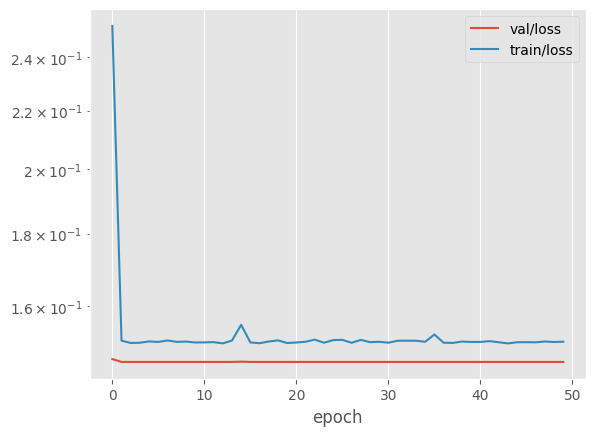

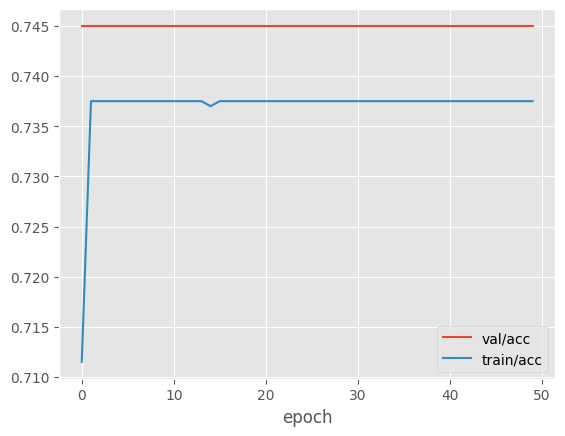

In [26]:
trainer = pl.Trainer(precision="bf16-mixed",
                gradient_clip_val=20,
                max_epochs=max_epochs, log_every_n_steps=3, 
                
                # enable_progress_bar=False, enable_model_summary=False
                )
trainer.fit(model=net, train_dataloaders=dl_train, val_dataloaders=dl_val)

# look at hist
df_hist = read_metrics_csv(trainer.logger.experiment.metrics_file_path).ffill().bfill()
for key in ['loss']:
    df_hist[[c for c in df_hist.columns if key in c]].plot(logy=True)
    
for key in ['acc']:
    df_hist[[c for c in df_hist.columns if key in c]].plot()
df_hist

# predict
dl_test = dm.test_dataloader()
# print(f"training with x_feats={x_feats} with c={c}")
rs = trainer.test(net, dataloaders=[dl_train, dl_val, dl_test])

testval_metrics = calc_metrics(dm, trainer, net, use_val=True)
rs = rename(rs)
# rs['test'] = {**rs['test'], **test_metrics}
rs['test']['acc_lie_lie'] = testval_metrics['acc_lie_lie']
rs['testval_metrics'] = rs['test']
